# System (AC) performance ratio over time

In [7]:
import os
import datetime
import copy

import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as plty
plty.init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
cf.set_config_file(theme='ggplot')

import pandas as pd
import numpy as np

from analysis_utils import pv_time_series as pvts

import pymongo

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import data

In [8]:
client = pymongo.MongoClient('localhost', 27017)

In [9]:
ts_data = client.pvdaq.time_series_data

In [10]:
array_pr = ts_data.find({'aggregation': 'hourly'}, {'measdatetime': 1, 'system_performance_ratio': 1, 'system_id': 1})
my_list = list(array_pr)
df = pd.DataFrame(my_list)

In [11]:
series_list = []
for s_id, s_id_group in df.groupby('system_id'):
    series = pd.Series(s_id_group['system_performance_ratio'])
    series.index = pd.to_datetime(s_id_group['measdatetime'])
    series.name = s_id
    if series.dropna().empty:
        continue
    series_list.append(series)
systems_df = pd.concat(series_list, axis=1)

## Clean data

In [12]:
systems_df = systems_df.resample('D').mean()
systems_df = systems_df[systems_df.index < '2017']

In [13]:
quality = pvts.df_data_quality(systems_df)

In [14]:
to_drop = []
for key in quality:
    site_quality = quality[key]
    if site_quality['pct'] < .8:
        to_drop.append(key)
        continue
    if site_quality['span (Y)'] < 2:
        to_drop.append(key)
        continue
for i in [1433, 1204, 1284, 1231]:
    if i not in to_drop:
        to_drop.append(i)

In [15]:
systems_df.drop(to_drop, inplace=True, axis=1)

In [16]:
systems_df = systems_df[systems_df.first_valid_index(): systems_df.last_valid_index()].copy()

# General trend and data quality

## Look at how system performance ratio changes

In [17]:
systems_df.iplot(kind='scatter')

<IPython.core.display.Javascript object>


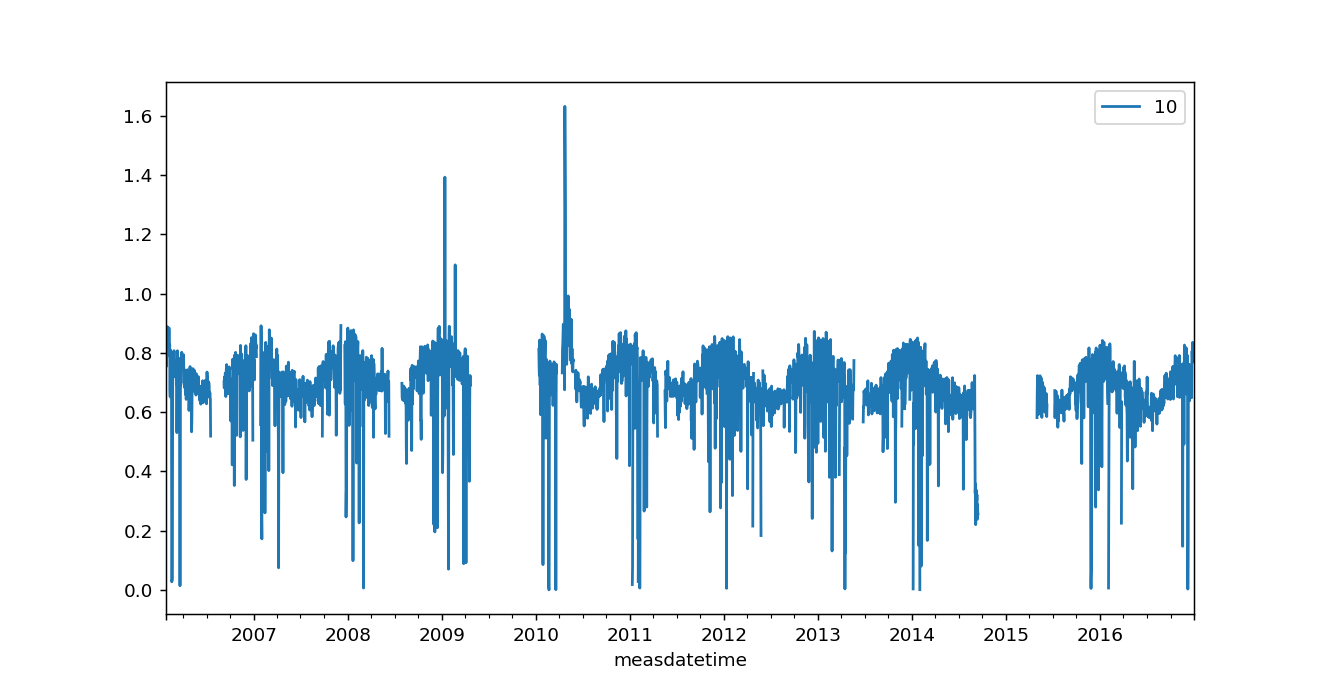

In [19]:
systems_df[[10]].plot()

# Caclulate degradation rates

In [12]:
def ols_organized(df):
    vals = []
    errors = []
    for i, site in enumerate(df):
        this_site = df[site]
        linear_reg = pvts.calc_degredation_rate_ols(this_site)
        vals.append(pd.Series(linear_reg['deg_rate'], index=[site], name='OLS'))
        errors.append(pd.Series(linear_reg['rmse'], index=[site], name='OLS'))
    pct_deg_ols = pd.concat(vals)
    errors_ols = pd.concat(errors)
    return pct_deg_ols, errors_ols

In [13]:
def csd_ols_organized(df):
    vals = []
    errors = []
    for i, site in enumerate(df):
        this_site = df[site]
        linear_reg = pvts.calc_degredation_rate_seasonal_decomp(this_site)
        vals.append(pd.Series(linear_reg['deg_rate'], index=[site], name='CSD+OLS'))
        errors.append(pd.Series(linear_reg['rmse'], index=[site], name='CSD+OLS'))
    pct_deg_csd = pd.concat(vals)
    errors_csd = pd.concat(errors)
    return pct_deg_csd, errors_csd

In [14]:
def lowess_ols_organized(df):
    vals = []
    errors = []
    for i, site in enumerate(df):
        this_site = df[site]
        linear_reg = pvts.calc_degredation_rate_lowess(this_site)
        vals.append(pd.Series(linear_reg['deg_rate'], index=[site], name='LOWESS+OLS'))
        errors.append(pd.Series(linear_reg['rmse'], index=[site], name='LOWESS+OLS'))
    pct_deg_lowess = pd.concat(vals)
    errors_lowess = pd.concat(errors)
    return pct_deg_lowess, errors_lowess

## Original data

### OLS

In [15]:
pct_deg_ols, errors_ols = ols_organized(systems_df)

### OLS, seasonally decomposed trend

In [16]:
pct_deg_csd, errors_csd = csd_ols_organized(systems_df)

### OLS, LOWESS trend

In [17]:
pct_deg_lowess, errors_lowess = lowess_ols_organized(systems_df)

### Results

In [18]:
orig_data = pd.concat([pct_deg_ols, pct_deg_csd, pct_deg_lowess], axis=1)
orig_data

OLS   CSD+OLS  LOWESS+OLS
10   -0.731969 -1.775266   -0.848314
18   -0.137160 -0.821282    0.265526
33   -1.284042 -1.740758   -0.700979
34   -0.922831 -0.851100   -0.903781
35   -0.189407 -3.100531   -0.794165
1200 -2.115332  2.630684   -5.327617
1237 -0.471523 -7.787173   -0.923484
1239  0.949804  0.009655    1.221896
1276  0.447554  0.833620    0.433433
1277  0.398323  0.423936    0.415287
1278 -0.670768 -1.157018   -1.338087
1289 -0.725963 -2.895691   -1.328719
1432  2.007809  0.965529    2.300669

In [19]:
orig_data.describe()

OLS    CSD+OLS  LOWESS+OLS
count  13.000000  13.000000   13.000000
mean   -0.265039  -1.174261   -0.579103
std     1.046580   2.555381    1.786712
min    -2.115332  -7.787173   -5.327617
25%    -0.731969  -1.775266   -0.923484
50%    -0.471523  -0.851100   -0.794165
75%     0.398323   0.423936    0.415287
max     2.007809   2.630684    2.300669

In [20]:
orig_data.iplot(kind='hist', subplots=True, shape=(3,1), title='Degradation rates')

In [21]:
orig_errors = pd.concat([errors_ols, errors_csd, errors_lowess], axis=1)
orig_errors

OLS   CSD+OLS  LOWESS+OLS
10    0.119627  0.048258    0.011582
18    0.103681  0.012095    0.008471
33    0.174275  0.011221    0.006272
34    0.050398  0.006532    0.002758
35    0.067264  0.025336    0.004711
1200  0.162263  0.003676    0.017107
1237  0.199516  0.016321    0.011511
1239  0.164075  0.016910    0.007230
1276  0.046596  0.002436    0.001976
1277  0.052047  0.007567    0.001936
1278  0.090106  0.019603    0.008711
1289  0.120522  0.018455    0.003007
1432  0.186337  0.015681    0.010281

In [22]:
orig_errors.describe()

OLS    CSD+OLS  LOWESS+OLS
count  13.000000  13.000000   13.000000
mean    0.118208   0.015699    0.007350
std     0.054885   0.011837    0.004550
min     0.046596   0.002436    0.001936
25%     0.067264   0.007567    0.003007
50%     0.119627   0.015681    0.007230
75%     0.164075   0.018455    0.010281
max     0.199516   0.048258    0.017107

## Outliers removed (abs(zscore) > 3)

In [23]:
systems_df_rm_outliers = copy.deepcopy(systems_df)
for site in sorted(systems_df_rm_outliers):
    systems_df_rm_outliers[site] = \
        systems_df_rm_outliers[site].drop(pvts.get_outlier_indices_zscore(systems_df_rm_outliers[site]))

### OLS

In [24]:
pct_deg_ols, errors_ols = ols_organized(systems_df_rm_outliers)

### OLS, seasonally decomposed trend

In [25]:
pct_deg_csd, errors_csd = csd_ols_organized(systems_df_rm_outliers)

### OLS, LOWESS trend

In [26]:
pct_deg_lowess, errors_lowess = lowess_ols_organized(systems_df_rm_outliers)

### Results

In [27]:
rm_outliers_data = pd.concat([pct_deg_ols, pct_deg_csd, pct_deg_lowess], axis=1)
rm_outliers_data

OLS   CSD+OLS  LOWESS+OLS
10   -0.663595 -1.557255   -0.894844
18    0.043730 -0.529653    0.229458
33   -0.898141 -1.138905   -0.701884
34   -0.803000 -0.791489   -0.953838
35    0.045064 -1.375147   -0.699058
1200 -3.838299  1.919544   -4.905882
1237  0.413013 -5.052079   -1.065976
1239  0.886916 -0.041871    1.240710
1276  0.342789  0.715693    0.471078
1277  0.420939  0.473780    0.410962
1278 -1.110733 -1.754006   -1.289631
1289 -0.476651 -2.616348   -1.236303
1432  2.564698  1.960439    2.265264

In [28]:
rm_outliers_data.describe()

OLS    CSD+OLS  LOWESS+OLS
count  13.000000  13.000000   13.000000
mean   -0.236405  -0.752869   -0.548457
std     1.448915   1.889959    1.690444
min    -3.838299  -5.052079   -4.905882
25%    -0.803000  -1.557255   -1.065976
50%     0.043730  -0.791489   -0.701884
75%     0.413013   0.473780    0.410962
max     2.564698   1.960439    2.265264

In [29]:
rm_outliers_data.iplot(kind='hist', subplots=True, shape=(3,1), title='Degradation Rates')

In [30]:
rm_outliers_errors = pd.concat([errors_ols, errors_csd, errors_lowess], axis=1)
rm_outliers_errors

OLS   CSD+OLS  LOWESS+OLS
10    0.082873  0.043588    0.011945
18    0.070618  0.009370    0.007852
33    0.115984  0.010310    0.006198
34    0.044833  0.004692    0.002761
35    0.062547  0.016193    0.004127
1200  0.122876  0.002643    0.017897
1237  0.151369  0.012950    0.010554
1239  0.163013  0.016640    0.007198
1276  0.044110  0.002291    0.001998
1277  0.049704  0.006793    0.002149
1278  0.080457  0.016255    0.008871
1289  0.081323  0.017653    0.003060
1432  0.112264  0.010651    0.010467

In [31]:
rm_outliers_errors.describe()

OLS    CSD+OLS  LOWESS+OLS
count  13.000000  13.000000   13.000000
mean    0.090921   0.013079    0.007314
std     0.039215   0.010594    0.004671
min     0.044110   0.002291    0.001998
25%     0.062547   0.006793    0.003060
50%     0.081323   0.010651    0.007198
75%     0.115984   0.016255    0.010467
max     0.163013   0.043588    0.017897

## Compare to original dataset findings

In [32]:
(orig_data.mean() - rm_outliers_data.mean()) / orig_data.mean() * 100

OLS           10.803527
CSD+OLS       35.885728
LOWESS+OLS     5.291869
dtype: float64

In [33]:
(orig_data.std() - rm_outliers_data.std()) / orig_data.std() * 100

OLS          -38.442819
CSD+OLS       26.040041
LOWESS+OLS     5.387990
dtype: float64

In [34]:
(orig_errors.mean() - rm_outliers_errors.mean()) / orig_errors.mean() * 100

OLS           23.084154
CSD+OLS       16.689572
LOWESS+OLS     0.498527
dtype: float64

In [35]:
(orig_errors.std() - rm_outliers_errors.std()) / orig_errors.std() * 100

OLS           28.549922
CSD+OLS       10.503777
LOWESS+OLS    -2.657957
dtype: float64

## Fix range [0, 1]

In [36]:
systems_df_valid_range = copy.deepcopy(systems_df)
for site in sorted(systems_df_valid_range):
    this_site = systems_df_valid_range[site]
    systems_df_valid_range[site] = this_site.drop(pvts.get_out_of_range_indices(this_site, low=0, high=1))

### OLS

In [37]:
pct_deg_ols, errors_ols = ols_organized(systems_df_valid_range)

### OLS, seasonally decomposed trend

In [38]:
pct_deg_csd, errors_csd = csd_ols_organized(systems_df_valid_range)

### OLS, LOWESS trend

In [39]:
pct_deg_lowess, errors_lowess = lowess_ols_organized(systems_df_valid_range)

### Results

In [40]:
valid_range_data = pd.concat([pct_deg_ols, pct_deg_csd, pct_deg_lowess], axis=1)
valid_range_data

OLS   CSD+OLS  LOWESS+OLS
10   -0.710599 -1.756319   -0.848405
18   -0.137160 -0.821282    0.265526
33   -0.961019 -1.452662   -0.733728
34   -0.882954 -0.750305   -0.838067
35   -0.189407 -3.100531   -0.794165
1200 -0.888046  2.237206   -4.453791
1237 -0.070958 -7.653650   -0.831736
1239  0.949804  0.009655    1.221896
1276  0.447554  0.833620    0.433433
1277  0.398323  0.423936    0.415287
1278 -0.670768 -1.157018   -1.338087
1289 -0.513624 -2.759282   -1.317634
1432  2.007809  0.965529    2.300669

In [41]:
valid_range_data.describe()

OLS    CSD+OLS  LOWESS+OLS
count  13.000000  13.000000   13.000000
mean   -0.093926  -1.152392   -0.501446
std     0.863515   2.468540    1.596715
min    -0.961019  -7.653650   -4.453791
25%    -0.710599  -1.756319   -0.848405
50%    -0.189407  -0.821282   -0.794165
75%     0.398323   0.423936    0.415287
max     2.007809   2.237206    2.300669

In [42]:
valid_range_data.iplot(kind='hist', subplots=True, shape=(3,1))

In [43]:
valid_range_errors = pd.concat([errors_ols, errors_csd, errors_lowess], axis=1)
valid_range_errors

OLS   CSD+OLS  LOWESS+OLS
10    0.116457  0.047665    0.011589
18    0.103681  0.012095    0.008471
33    0.166916  0.008916    0.006713
34    0.048690  0.005080    0.002227
35    0.067264  0.025336    0.004711
1200  0.156011  0.003157    0.013860
1237  0.196684  0.015363    0.010013
1239  0.164075  0.016910    0.007230
1276  0.046596  0.002436    0.001976
1277  0.052047  0.007567    0.001936
1278  0.090106  0.019603    0.008711
1289  0.110958  0.017738    0.002965
1432  0.186337  0.015681    0.010281

In [44]:
valid_range_errors.describe()

OLS    CSD+OLS  LOWESS+OLS
count  13.000000  13.000000   13.000000
mean    0.115832   0.015196    0.006976
std     0.053714   0.011915    0.003962
min     0.046596   0.002436    0.001936
25%     0.067264   0.007567    0.002965
50%     0.110958   0.015363    0.007230
75%     0.164075   0.017738    0.010013
max     0.196684   0.047665    0.013860

## Compare to original data

In [45]:
(orig_data.mean() - valid_range_data.mean()) / orig_data.mean() * 100

OLS           64.561266
CSD+OLS        1.862333
LOWESS+OLS    13.409784
dtype: float64

In [46]:
(orig_data.std() - valid_range_data.std()) / orig_data.std() * 100

OLS           17.491717
CSD+OLS        3.398357
LOWESS+OLS    10.633894
dtype: float64

In [47]:
(orig_errors.mean() - valid_range_errors.mean()) / orig_errors.mean() * 100

OLS           2.009826
CSD+OLS       3.206812
LOWESS+OLS    5.096150
dtype: float64

In [48]:
(orig_errors.std() - valid_range_errors.std()) / orig_errors.std() * 100

OLS            2.133427
CSD+OLS       -0.656636
LOWESS+OLS    12.918730
dtype: float64

# Compare each method for original data, outlier removal, valid range

## OLS

In [49]:
ols_data = pd.concat([orig_data['OLS'], rm_outliers_data['OLS'], valid_range_data['OLS']], axis=1)
ols_data.columns = ['orig', 'zscore', 'valid_range']
ols_errors = pd.concat([orig_errors['OLS'], rm_outliers_errors['OLS'], valid_range_errors['OLS']], axis=1)
ols_errors.columns = ['orig', 'zscore', 'valid_range']

In [50]:
ols_data.describe()

orig     zscore  valid_range
count  13.000000  13.000000    13.000000
mean   -0.265039  -0.236405    -0.093926
std     1.046580   1.448915     0.863515
min    -2.115332  -3.838299    -0.961019
25%    -0.731969  -0.803000    -0.710599
50%    -0.471523   0.043730    -0.189407
75%     0.398323   0.413013     0.398323
max     2.007809   2.564698     2.007809

In [51]:
ols_errors.describe()

orig     zscore  valid_range
count  13.000000  13.000000    13.000000
mean    0.118208   0.090921     0.115832
std     0.054885   0.039215     0.053714
min     0.046596   0.044110     0.046596
25%     0.067264   0.062547     0.067264
50%     0.119627   0.081323     0.110958
75%     0.164075   0.115984     0.164075
max     0.199516   0.163013     0.196684

In [52]:
ols_data.describe().T['mean'].std()

0.091651141932296024

## CSD+OLS

In [53]:
csd_data = pd.concat([orig_data['CSD+OLS'], rm_outliers_data['CSD+OLS'], valid_range_data['CSD+OLS']], axis=1)
csd_data.columns = ['orig', 'zscore', 'valid_range']
csd_errors = pd.concat([orig_errors['CSD+OLS'], rm_outliers_errors['CSD+OLS'], valid_range_errors['CSD+OLS']], axis=1)
csd_errors.columns = ['orig', 'zscore', 'valid_range']

In [54]:
csd_data.describe()

orig     zscore  valid_range
count  13.000000  13.000000    13.000000
mean   -1.174261  -0.752869    -1.152392
std     2.555381   1.889959     2.468540
min    -7.787173  -5.052079    -7.653650
25%    -1.775266  -1.557255    -1.756319
50%    -0.851100  -0.791489    -0.821282
75%     0.423936   0.473780     0.423936
max     2.630684   1.960439     2.237206

In [55]:
csd_errors.describe()

orig     zscore  valid_range
count  13.000000  13.000000    13.000000
mean    0.015699   0.013079     0.015196
std     0.011837   0.010594     0.011915
min     0.002436   0.002291     0.002436
25%     0.007567   0.006793     0.007567
50%     0.015681   0.010651     0.015363
75%     0.018455   0.016255     0.017738
max     0.048258   0.043588     0.047665

In [56]:
csd_data.describe().T['mean'].std()

0.23723006211288958

## LOWESS+OLS

In [57]:
lowess_data = pd.concat([orig_data['LOWESS+OLS'], rm_outliers_data['LOWESS+OLS'], valid_range_data['LOWESS+OLS']], axis=1)
lowess_data.columns = ['orig', 'zscore', 'valid_range']
lowess_errors = pd.concat([orig_errors['LOWESS+OLS'], rm_outliers_errors['LOWESS+OLS'], valid_range_errors['LOWESS+OLS']], axis=1)
lowess_errors.columns = ['orig', 'zscore', 'valid_range']

In [58]:
lowess_data.describe()

orig     zscore  valid_range
count  13.000000  13.000000    13.000000
mean   -0.579103  -0.548457    -0.501446
std     1.786712   1.690444     1.596715
min    -5.327617  -4.905882    -4.453791
25%    -0.923484  -1.065976    -0.848405
50%    -0.794165  -0.701884    -0.794165
75%     0.415287   0.410962     0.415287
max     2.300669   2.265264     2.300669

In [59]:
lowess_errors.describe()

orig     zscore  valid_range
count  13.000000  13.000000    13.000000
mean    0.007350   0.007314     0.006976
std     0.004550   0.004671     0.003962
min     0.001936   0.001998     0.001936
25%     0.003007   0.003060     0.002965
50%     0.007230   0.007198     0.007230
75%     0.010281   0.010467     0.010013
max     0.017107   0.017897     0.013860

In [60]:
lowess_data.describe().T['mean'].std()

0.039114558959806887